In [1]:
import time
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from numba import jit, prange

In [2]:
from utils.generate_phrases import generate_random_phrase, generate_random_phrase_with_mutation, alphabet

In [ ]:
class MonkeyModel():
    def fitness():
        return

In [3]:
def num_char_certo(y_true:str, y_pred:str):
    count = 0
    for i, letter in enumerate(y_true):
        if letter == y_pred[i]:
            count += 1
    
    count = count / len(y_true)
    return count

In [12]:
def genetic_drift(phrases, seed=2024):
    random.seed(seed)
    new_phrases = np.empty(len(phrases), dtype=object)
    for i in range(len(phrases)):
        new_phrases[i] = np.random.choice(phrases)
    return new_phrases

def crossover(new_phrases:np.array, m:float=0.9, recomb_mode="add"):
    '''
    Recombinação \n
    Pegar m% das frases, selecionar aleatoriamente 2 frases e trocar um pedaço delas dado um crossoverpoint aleatório
    '''
    n_phrases = len(new_phrases)
    phrase_size = len(new_phrases[0])
    for i in range(round(m * n_phrases)):
        crossover_point = np.random.randint(1, phrase_size - 1)
        index_phrase1, index_phrase2 = np.random.randint(0, n_phrases, size=2)

        phrase1 = new_phrases[index_phrase1]
        phrase2 = new_phrases[index_phrase2]

        new_phrase_1 = phrase1[:crossover_point] + phrase2[crossover_point:]
        new_phrase_2 = phrase2[:crossover_point] + phrase1[crossover_point:]
        if recomb_mode == "add":
            new_phrases = np.append(new_phrases, new_phrase_1)
            new_phrases = np.append(new_phrases, new_phrase_2)
        else:
            new_phrases[index_phrase1] = new_phrase_1
            new_phrases[index_phrase2] = new_phrase_2
    return new_phrases

def selection(new_phrases, phrase):
    # best_phrase = new_phrases[0]
    # score = num_char_certo(phrase, best_phrase)
    # for i in range(1, n_phrases):
    #     if num_char_certo(phrase, new_phrases[i]) > score:
    #         best_phrase = new_phrases[i]
    #         score = num_char_certo(phrase, best_phrase)
    return max(new_phrases, key=lambda p: num_char_certo(phrase, p))

# A partir da implementação anterior implementar Recombinação
* Use frases mais longas, eg, em um alfabeto de 4
possibilidades, use strings de 15 caracteres

- Implementar “conjugação” de duas vias
- Com uma certa frequência, maior do que a da mutação
- Selecionar dois pais
- Duas strings dão origem a duas strings
- Ponto de corte entre frases

In [13]:
def generate_phrases(phrase, u=0.1, m=0.9, n_phrases=50, gen_max=1e6, recomb_mode=""):
    for letter in phrase:
        if letter not in alphabet:
            raise ValueError(f"Letter {letter} not in alphabet")
    
    phrase_size = len(phrase)
    gen = 0
    initial_phrases = np.array([generate_random_phrase(phrase_size, alphabet) for _ in range(n_phrases)])
    new_phrases = initial_phrases.copy()
    for gen in range(int(gen_max)):        
        if phrase in new_phrases:
            return initial_phrases, {"gen": gen, "reached": True}, new_phrases
        
        new_phrases = crossover(new_phrases, m, recomb_mode=recomb_mode)
        new_phrases = genetic_drift(new_phrases)
        best_phrase = selection(new_phrases, phrase)
        
        new_phrases = np.array([generate_random_phrase_with_mutation(best_phrase, alphabet=alphabet, u=u) for _ in range(n_phrases)])
        # gen += 1
    
    return initial_phrases, {"gen": gen, "reached": False}, new_phrases

In [14]:
def plot_graphs_and_describe(full_gens, m_list):
    d = {}

    for i in range(len(full_gens)):
        d[f"M{m_list[i]}"] = full_gens[i]

    df = pd.DataFrame(d)

    print(df.describe())

    df.boxplot()
    plt.xticks(rotation=45)
    plt.ylabel("Generations")
    plt.xlabel("Mutation rate")
    plt.show()

def run_exp(u, m_list, phrase, qntd_exp, n_phrases=5, recomb_mode=""):
    print("Generating phrases for different crossover rates: \n", m_list)
    med_gens = []
    full_gens = []
    t1 = time.time()
    for m in m_list:
        gens = []
        t1_epoch = time.time()
        for i in range(qntd_exp):
            initial_phrase, gen, new_phrases = generate_phrases(phrase, u, m, n_phrases, gen_max=1e7, recomb_mode=recomb_mode)
            gens.append(gen.get("gen"))
            if not gen.get("reached"):
                print(f"This experiment {i} did not reach the phrase")
        t2_epoch = time.time()
        print(f"Mutation rate: {u:.2f} | Mean generations: {round(np.mean(gens), 2):,} | Time taken: {t2_epoch-t1_epoch:.2f}s")

        med_gens.append(np.mean(gens))
        full_gens.append(gens)
    t2 = time.time()
    print("Mean generations: ", med_gens)
    print("Time taken: ", t2-t1)

    plt.plot(m_list, med_gens)
    plt.plot(m_list, med_gens, '*')
    plt.ylabel("Mean generations")
    plt.xlabel("Crossover rate")
    plt.show()

    plot_graphs_and_describe(full_gens, m_list)

Mean generations: 25.766666666666666
           M0.25
count  30.000000
mean   25.766667
std    11.613557
min    10.000000
25%    17.250000
50%    24.000000
75%    31.500000
max    57.000000


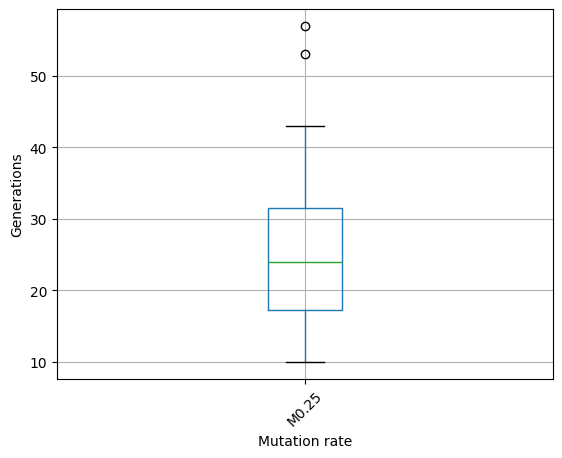

In [7]:
phrase = 'GAGCCCGAACGAGCTTTGCGTCT'
n_phrases = 100
u = 0.25
m = 0.75
n_exp = 30

seed = 2024
random.seed(seed)
np.random.seed(seed)

gens = []
for i in range(n_exp):
    initial_phrases, gen, new_phrases = generate_phrases(phrase, u=u, m=m, n_phrases=n_phrases)
    gen = gen.get("gen")
    gens.append(gen)

    # print(f"Took {gen:,} generations to generate the phrase '{phrase}' from '{initial_phrases}'")
    # print("\n Mutated to '{new_phrases}'")

mean_gen = sum(gens) / len(gens)
print(f"Mean generations: {mean_gen:,}")

plot_graphs_and_describe([gens], [u])

Generating phrases for different crossover rates: 
 [np.float64(0.25), np.float64(0.35), np.float64(0.44999999999999996), np.float64(0.5499999999999999), np.float64(0.6499999999999999), np.float64(0.7499999999999999), np.float64(0.8499999999999999), np.float64(0.9499999999999998)]
Mutation rate: 0.25 | Mean generations: 3.57 | Time taken: 0.34s
Mutation rate: 0.25 | Mean generations: 3.3 | Time taken: 0.32s
Mutation rate: 0.25 | Mean generations: 3.27 | Time taken: 0.35s
Mutation rate: 0.25 | Mean generations: 3.07 | Time taken: 0.35s
Mutation rate: 0.25 | Mean generations: 3.6 | Time taken: 0.40s
Mutation rate: 0.25 | Mean generations: 3.17 | Time taken: 0.40s
Mutation rate: 0.25 | Mean generations: 3.17 | Time taken: 0.43s
Mutation rate: 0.25 | Mean generations: 2.83 | Time taken: 0.39s
Mean generations:  [np.float64(3.566666666666667), np.float64(3.3), np.float64(3.2666666666666666), np.float64(3.066666666666667), np.float64(3.6), np.float64(3.1666666666666665), np.float64(3.1666666

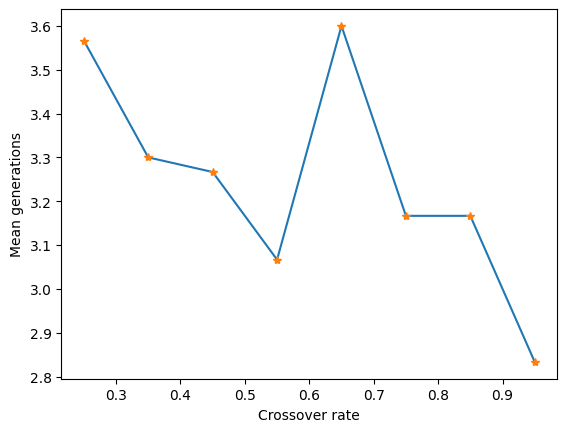

           M0.25      M0.35  M0.44999999999999996  M0.5499999999999999  \
count  30.000000  30.000000             30.000000            30.000000   
mean    3.566667   3.300000              3.266667             3.066667   
std     1.072648   0.876907              1.412587             1.112107   
min     2.000000   2.000000              1.000000             1.000000   
25%     3.000000   3.000000              3.000000             2.000000   
50%     4.000000   3.000000              3.000000             3.000000   
75%     4.000000   4.000000              3.750000             4.000000   
max     6.000000   6.000000              8.000000             6.000000   

       M0.6499999999999999  M0.7499999999999999  M0.8499999999999999  \
count            30.000000            30.000000            30.000000   
mean              3.600000             3.166667             3.166667   
std               1.220514             1.053183             0.874281   
min               1.000000             1.0000

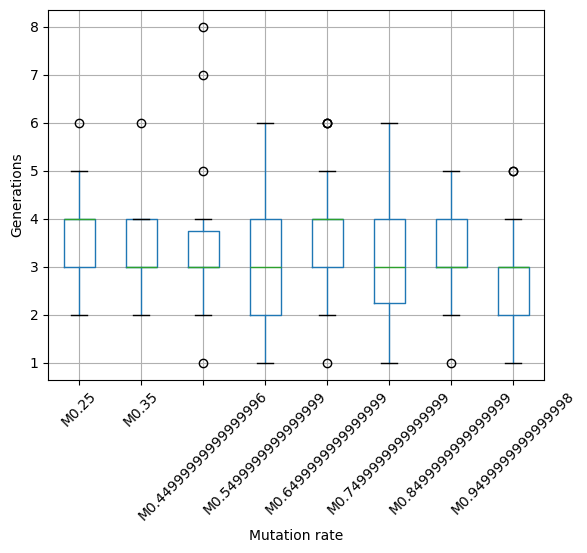

In [8]:
phrase = 'GAGCCCGAA'#CGAGCTTTGCGTCT'
n_phrases = 100
u = 0.25
m_list = [i for i in np.arange(0.25, 0.96, 0.1)]
n_exp = 30

seed = 2024
random.seed(seed)
np.random.seed(seed)

run_exp(u, m_list, phrase, n_exp, n_phrases=n_phrases)

# Incresing population before reducing it with selection

Generating phrases for different crossover rates: 
 [np.float64(0.25), np.float64(0.35), np.float64(0.44999999999999996), np.float64(0.5499999999999999), np.float64(0.6499999999999999), np.float64(0.7499999999999999), np.float64(0.8499999999999999)]
Mutation rate: 0.25 | Mean generations: 48.1 | Time taken: 6.83s
Mutation rate: 0.25 | Mean generations: 42.53 | Time taken: 6.39s
Mutation rate: 0.25 | Mean generations: 35.5 | Time taken: 5.64s
Mutation rate: 0.25 | Mean generations: 33.7 | Time taken: 5.49s
Mutation rate: 0.25 | Mean generations: 30.53 | Time taken: 5.27s
Mutation rate: 0.25 | Mean generations: 28.2 | Time taken: 5.12s
Mutation rate: 0.25 | Mean generations: 29.67 | Time taken: 5.58s
Mean generations:  [np.float64(48.1), np.float64(42.53333333333333), np.float64(35.5), np.float64(33.7), np.float64(30.533333333333335), np.float64(28.2), np.float64(29.666666666666668)]
Time taken:  40.315332651138306


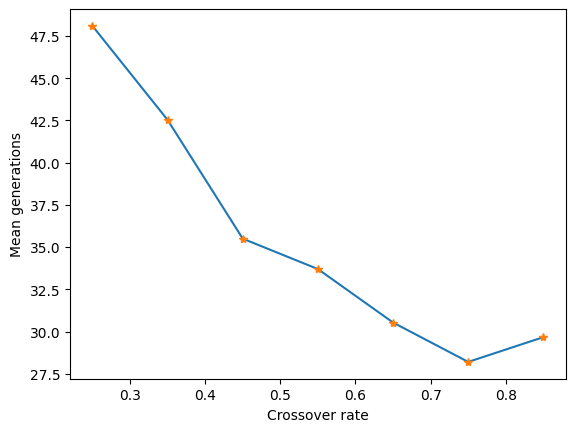

            M0.25       M0.35  M0.44999999999999996  M0.5499999999999999  \
count   30.000000   30.000000             30.000000            30.000000   
mean    48.100000   42.533333             35.500000            33.700000   
std     36.005124   32.287217             23.115527            19.568007   
min     10.000000    8.000000              9.000000             9.000000   
25%     20.250000   19.250000             19.000000            19.750000   
50%     42.500000   39.500000             28.500000            28.000000   
75%     60.000000   50.000000             46.250000            46.250000   
max    151.000000  178.000000            100.000000            85.000000   

       M0.6499999999999999  M0.7499999999999999  M0.8499999999999999  
count            30.000000            30.000000            30.000000  
mean             30.533333            28.200000            29.666667  
std              19.288613            21.112833            12.693559  
min               9.000000     

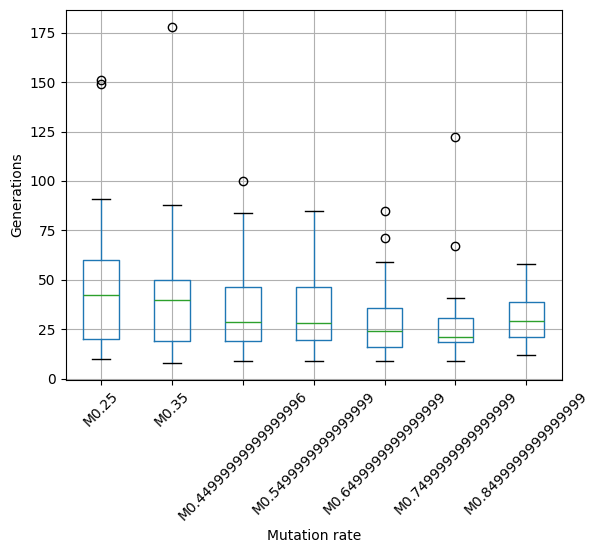

In [ ]:
phrase = 'GAGCCCGAACGAGCTTTGCGTCT'
n_phrases = 100
u = 0.25
m_list = [i for i in np.arange(0.25, 0.95, 0.1)]
n_exp = 30

seed = 2024
random.seed(seed)
np.random.seed(seed)

run_exp(u, m_list, phrase, n_exp, n_phrases=n_phrases)

# Substituting crossover by its originals

Generating phrases for different crossover rates: 
 [np.float64(0.25), np.float64(0.35), np.float64(0.44999999999999996), np.float64(0.5499999999999999), np.float64(0.6499999999999999), np.float64(0.7499999999999999), np.float64(0.8499999999999999)]
Mutation rate: 0.25 | Mean generations: 86.93 | Time taken: 11.31s
Mutation rate: 0.25 | Mean generations: 97.9 | Time taken: 12.87s
Mutation rate: 0.25 | Mean generations: 76.67 | Time taken: 10.21s
Mutation rate: 0.25 | Mean generations: 93.37 | Time taken: 12.39s
Mutation rate: 0.25 | Mean generations: 67.2 | Time taken: 9.56s
Mutation rate: 0.25 | Mean generations: 57.77 | Time taken: 8.04s
Mutation rate: 0.25 | Mean generations: 69.63 | Time taken: 9.96s
Mean generations:  [np.float64(86.93333333333334), np.float64(97.9), np.float64(76.66666666666667), np.float64(93.36666666666666), np.float64(67.2), np.float64(57.766666666666666), np.float64(69.63333333333334)]
Time taken:  74.33291888237


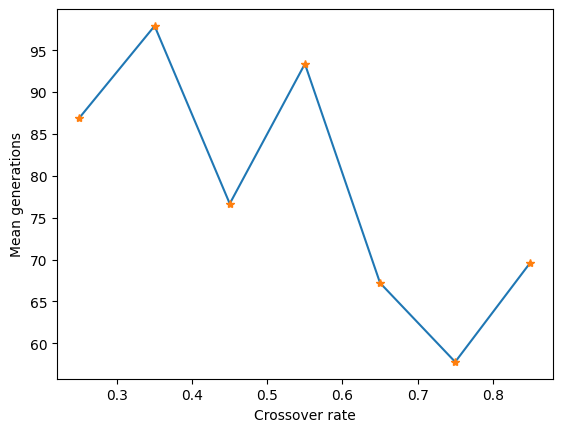

            M0.25       M0.35  M0.44999999999999996  M0.5499999999999999  \
count   30.000000   30.000000             30.000000            30.000000   
mean    86.933333   97.900000             76.666667            93.366667   
std     56.994212  107.676511             57.667497            70.863386   
min     14.000000   16.000000             13.000000            14.000000   
25%     42.000000   41.000000             36.750000            42.750000   
50%     83.000000   55.000000             53.500000            73.500000   
75%    107.500000   96.000000            113.000000           135.250000   
max    238.000000  465.000000            213.000000           333.000000   

       M0.6499999999999999  M0.7499999999999999  M0.8499999999999999  
count            30.000000            30.000000            30.000000  
mean             67.200000            57.766667            69.633333  
std              52.343297            54.705912            49.814472  
min              17.000000     

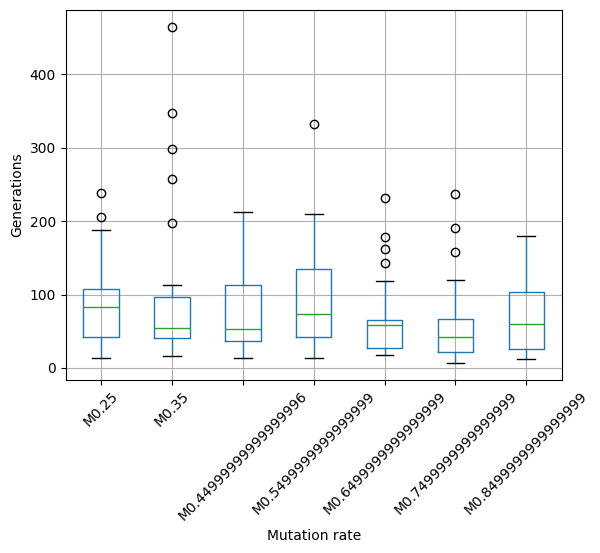

In [15]:
phrase = 'GAGCCCGAACGAGCTTTGCGTCT'
n_phrases = 100
u = 0.25
m_list = [i for i in np.arange(0.25, 0.95, 0.1)]
n_exp = 30

seed = 2024
random.seed(seed)
np.random.seed(seed)

run_exp(u, m_list, phrase, n_exp, n_phrases=n_phrases, recomb_mode=None)